# Getting Started with OneMax

This tutorial explains how to implement custom representations with the following components:

- [Representation](#Representation) as the _binary string_ representation.

- [Variator](#Variator) as the _random bit mutator_ which modifies each bit of the binary string with a fixed probability.

- [Evaluator](#Evaluator) as the _bit distance evaluator_ which sums all bits in a bit string.

- [Put Everything Together](#Put-Everything-Together) runs an evolutionary algorithm using the operators defined above, in addition to a stock selector.

## Representation

All custom representations must derive `evokit.core.population.Individual`.

At minimum, the implementation must do the following:
    
1. Initialise `.genome` to store the representation.

3. Override `.copy(..)` to return an independent copy.

The implementation must decide how to initialise new individuals. In this example, the class `BinaryString` implements a factory method `BinaryString.random(..)`, which creates a uniformly random bit string of the given length.

In [1]:
from __future__ import annotations
from typing import List, Self
from typing import override

In [2]:
from random import getrandbits
from evokit.core import Individual

class BinaryString(Individual[list[int]]):
    @override
    def __init__(self, value: list[int]) -> None:
        """Required.

        Initialise the genome.
        """
        self.genome: list[int] = value

    @override
    def copy(self: Self) -> Self:
        """Required.
        
        Ensure that operations performed on
        a copy do not affect to the original individual.
        """
        return type(self)(self.genome.copy())

    @staticmethod
    def random(len: int) -> BinaryString:
        """Not required.
        
        Initialise a random individual.
        """
        return BinaryString(
            (len * [0] +
                [int(digit)
                 for digit in bin(getrandbits(len))[2:]])[-len:]
        )

    @override
    def __str__(self: Self) -> str:
        """Not required.
        
        Return a text representation of the individual.
        """
        return str(self.genome)

## Variator

All custom variators must derive `evokit.core.variator.Variator`.

At minimum, the implementation must do the following:
    
1. Initialise `.arity` to specify how many parents are passed to `.vary`.

2. Override `.vary(..)` method to specify how to create new individuals from existing ones.
   Be sure to call `.copy` before making changes to an existing individual.

In this example, `.vary` receives an 1-tuple because `.arity=2`.

In [3]:
from random import random
from typing import Sequence

from evokit.core import Variator

class RandomBitMutator(Variator[BinaryString]):
    @override
    def __init__(self, mutation_rate: float):
        self.arity = 1

        # Not required. Raise an error if the mutation rate is too big or small.
        if (mutation_rate < 0 or mutation_rate > 1):
            raise ValueError(f"Mutation rate must be within {0} and {1}."
                             f"Got: {mutation_rate}")
        
        # The mutation rates is a parameter of the variator.
        self.mutation_rate = mutation_rate
    
    @override
    def vary(self, parents: Sequence[BinaryString]) -> tuple[BinaryString]:
        """Required.

        Produce new individuals from existing ones.
        
        Because `.arity=1` in the initialiser, `parents` will be a 1-tuple at runtime.
        """
        offspring = parents[0].copy()

        for i in range(0, len(offspring.genome)):
            if (random() < self.mutation_rate):
                offspring.genome[i] = 1 if offspring.genome[i] == 0 else 1

        return (offspring, parents[0].copy())

# Evaluator

All custom evaluators must derive `evokit.core.evaluator.Evaluator`.

At minimum, the implementation must override the `.evaluate(..)` method. This method should take one individual of the correct type, then return its fitness(es) in a tuple.

The `.evaluate_population(..)` method, which is not covered here, applies `.evaluate(..)` to each 

In this example, `.evaluate(..)` returns a 1-tuple because it uses only one measure of fitness. The method sums all bits in the `.genome` of a `BinaryString`.

In [4]:
from evokit.core import Evaluator
from typing import override

class BitDistanceEvaluator(Evaluator[BinaryString]):
    @override
    def evaluate(self, s1: BinaryString) -> tuple[float]:
        return (sum(s1.genome),)

## Put Everything Together

An evolutionary algorithm uses operators: evaluators, selectors, and variators. The algorithm should initialise with a population of individuals. These components, except for the selector and the algorithm itself, are already defined.

Because selectors and algorithms are independent to the representation, the framework provides generic ones. These components can be found in `evokit.evolvables.selectors` and `evokit.evolvables.algorithms`.

This example use an elitist (hall-of-fame) truncation selector, by combining the `Elitist` [interceptor](./interceptor.ipynb) and `core.selector.TruncationSelector`. The algorithm is a `SimpleLinearAlgorithm` which applies operators in this order:

  1. **evaluate** for selection
  2. **selection**
  3. *update population*
  4. **vary** parents
  5. *update population*

In [5]:
from evokit.evolvables.selectors import Elitist, TruncationSelector

from evokit.evolvables.algorithms import SimpleLinearAlgorithm

### Initialise Population

Create a number of `BinaryString` instances, then store them in a `Population`. This is the initial population.

In [6]:
from evokit.core import Population

BINSTRING_LENGTH: int = 1000
POPULATION_SIZE: int = 20
GENERATION_COUNT: int = 100
init_pop = Population[BinaryString]()

for i in range(0, POPULATION_SIZE):
    init_pop.append(BinaryString.random(BINSTRING_LENGTH))

### Define the Algorithm

Initialise operators, then initialise the algorithm with these operators.

In [7]:
ctrl: SimpleLinearAlgorithm = SimpleLinearAlgorithm(
    population=init_pop,
    variator=RandomBitMutator(0.1),
    selector=Elitist(TruncationSelector[BinaryString](POPULATION_SIZE)),
    evaluator = BitDistanceEvaluator()
)

### Run the Algorithm

Run the algorithm, then retain the best individual of each generation. Remember to call `copy`, so that operation on the individual in the population do not affect the retained copy.

In [8]:
bests: list[BinaryString] = []

for _ in range(GENERATION_COUNT):
    ctrl.step()
    bests.append(ctrl.population.best().copy())

### Analyse Results

Visualise best individuals of the first and last generations, note the difference.

In [9]:
print(f"Best individual of the first generation is {bests[0]}")
print(f"    with fitness {sum(bests[0].genome)}")
print(f"Best individual of the last generation is {bests[-1]}")
print(f"    with fitness {sum(bests[-1].genome)}")

Best individual of the first generation is [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,

Observe the training curve, and note that the increase in fitness slows down near convergence.

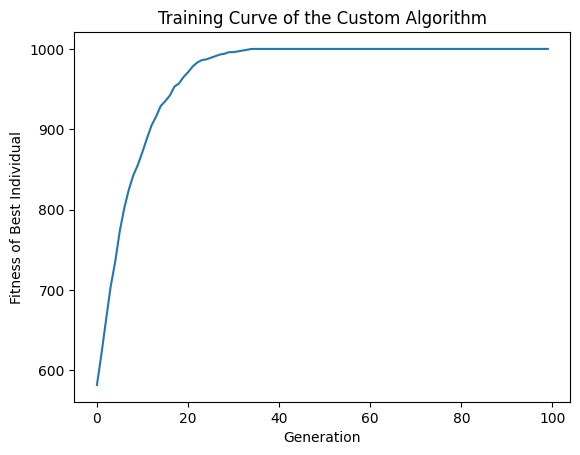

In [10]:
from matplotlib import pyplot as plt

plt.title('Training Curve of the Custom Algorithm')
plt.xlabel('Generation')
plt.ylabel('Fitness of Best Individual')
plt.plot([i for i in range(len(bests))], [sum(x.genome) for x in bests])
plt.show()